---
title: Bayesian Regularization
---

In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cvxpy as cp

Let us consider the temperature anomalies dataset that we already used in the last lecture. 

   Year  Anomaly
0  1850    -0.46
1  1851    -0.17
2  1852    -0.02
3  1853    -0.12
4  1854    -0.28


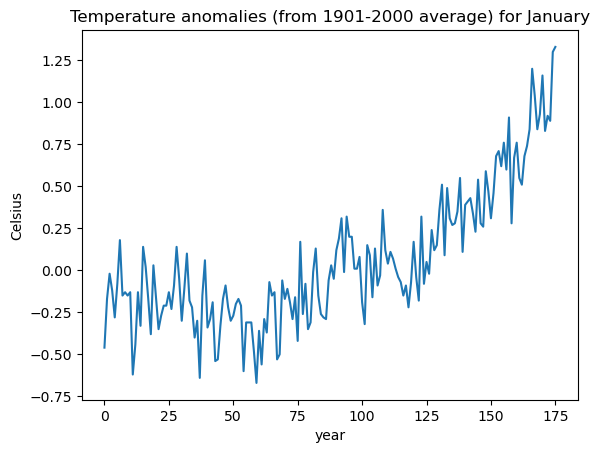

In [50]:
temp_jan = pd.read_csv('TempAnomalies_January.csv', skiprows=4)
print(temp_jan.head())
y = temp_jan['Anomaly']
plt.plot(y)
plt.xlabel('year')
plt.ylabel('Celsius')
plt.title('Temperature anomalies (from 1901-2000 average) for January')
plt.show()

The $X$ matrix for our high-dimensional regression model is calculated as follows. 

In [51]:
n = len(y)
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    X = np.column_stack([X, xc])
print(X)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 173. 172. ...   1.   0.  -0.]
 [  1. 174. 173. ...   2.   1.   0.]
 [  1. 175. 174. ...   3.   2.   1.]]


### Posterior corresponding to Normal Prior

Consider the prior $\beta \sim N(0, Q)$ along with likelihood given by $N(X \beta, \sigma^2 I)$. The posterior of $\beta$ (given the data and $\sigma$) is then: 
\begin{align*}
   \beta \mid \text{data}, \sigma \sim N \left(\left(\frac{X^T
                          X}{\sigma^2} + Q^{-1}  \right)^{-1} \frac{X^T y}{\sigma^2},  \left(\frac{X^T X}{\sigma^2} + Q^{-1} \right)^{-1}\right). 
\end{align*}
Given $\tau$ (and a large positive $C$), we take $Q$ to be the diagonal matrix with diagonals $C, C, \tau^2, \dots, \tau^2$. The code below computes the posterior mean: 
\begin{equation*}
   \left(\frac{X^T
                          X}{\sigma^2} + Q^{-1}  \right)^{-1} \frac{X^T y}{\sigma^2}. 
\end{equation*}
for fixed $C$, $\tau$ and $\sigma$. 

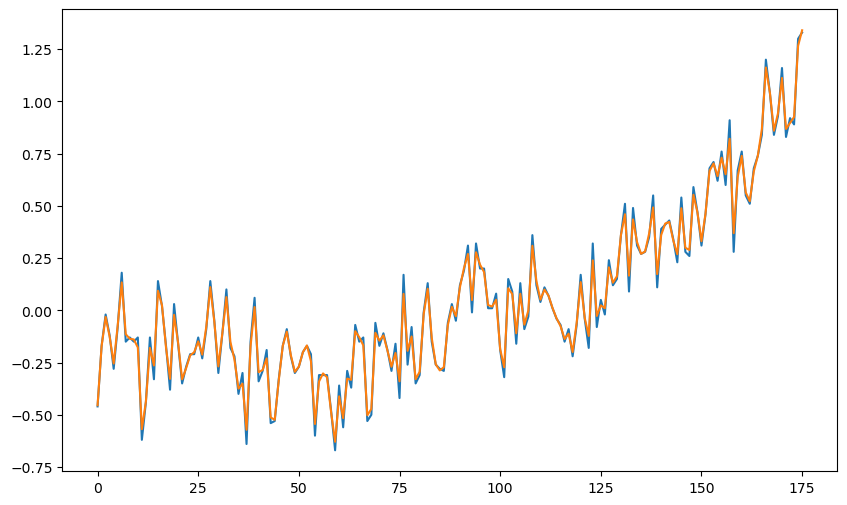

In [52]:
# Posterior mean of beta with fixed tau and sig
C = 10**10
tau = 0.0001
tau = 1
#tau = .0001
sig = 0.2
Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))

XTX = np.dot(X.T, X)
TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
XTy = np.dot(X.T, y)

betahat = np.dot(TempMat, XTy/(sig ** 2))
muhat = np.dot(X, betahat)

plt.figure(figsize = (10, 6))
plt.plot(y)
plt.plot(muhat)
plt.show()

We showed in class that this posterior mean coincides with the ridge regression estimate from last lecture provided the tuning parameter $\lambda$ in ridge regression is related to $\tau$ and $\sigma$ via $\lambda = \sigma^2/\tau^2$. This can be verified as follows. 

In [53]:
#below penalty_start = 2 means that b0 and b1 are not included in the penalty
def solve_ridge(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

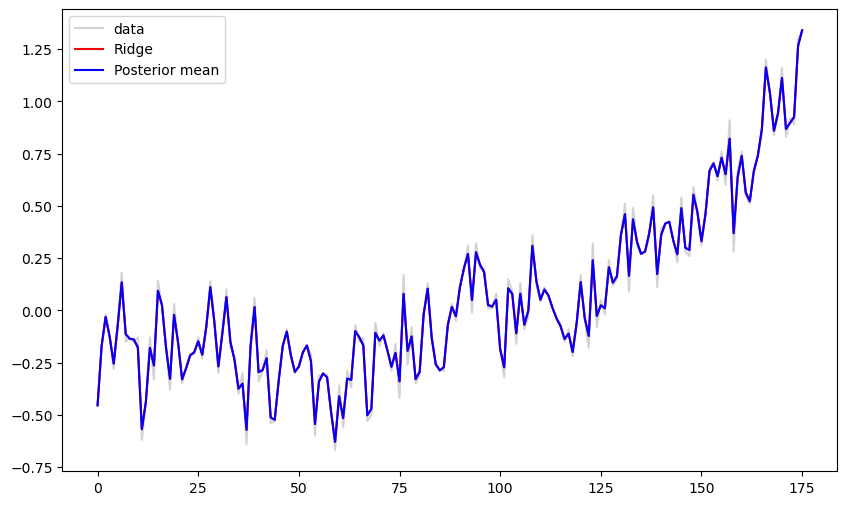

[[-4.54318547e-01 -4.54318548e-01]
 [-1.71984865e-01 -1.71984865e-01]
 [-3.16875161e-02 -3.16875106e-02]
 [-1.25841198e-01 -1.25841197e-01]
 [-2.54672707e-01 -2.54672707e-01]
 [-7.23788867e-02 -7.23788882e-02]
 [ 1.33661090e-01  1.33661091e-01]
 [-1.14459781e-01 -1.14459774e-01]
 [-1.36175761e-01 -1.36175758e-01]
 [-1.39426580e-01 -1.39426585e-01]
 [-1.77757943e-01 -1.77757940e-01]
 [-5.69051044e-01 -5.69051042e-01]
 [-4.37238510e-01 -4.37238509e-01]
 [-1.79976871e-01 -1.79976871e-01]
 [-2.63959894e-01 -2.63959891e-01]
 [ 9.35404352e-02  9.35404360e-02]
 [ 2.42494730e-02  2.42494753e-02]
 [-1.78618302e-01 -1.78618301e-01]
 [-3.28085237e-01 -3.28085237e-01]
 [-2.17161205e-02 -2.17161196e-02]
 [-1.54944818e-01 -1.54944816e-01]
 [-3.30302181e-01 -3.30302181e-01]
 [-2.76698624e-01 -2.76698624e-01]
 [-2.15490024e-01 -2.15490021e-01]
 [-2.00566655e-01 -2.00566657e-01]
 [-1.48568204e-01 -1.48568203e-01]
 [-2.11967970e-01 -2.11967969e-01]
 [-7.90341525e-02 -7.90341505e-02]
 [ 1.11164291e-01  1

In [54]:
b_ridge = solve_ridge(X, y, lambda_val = (sig ** 2)/(tau ** 2))
ridge_fitted = np.dot(X, b_ridge)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray', label = 'data')
plt.plot(ridge_fitted, color = 'red', label = 'Ridge')
plt.plot(muhat, color = 'blue', label = 'Posterior mean')
plt.legend()
plt.show()
print(np.column_stack((ridge_fitted, muhat)))

We next perform posterior inference for all the parameters $\beta, \sigma, \tau$. We follow the method described in lecture. First we take a grid of values of $\tau$ and $\sigma$ and compute the posterior (on the logarithmic scale) of $\tau$ and $\sigma$. The posterior for $\tau$ and $\sigma$ (derived in class) is given by: 
\begin{align*}
&  f_{\tau, \sigma \mid \text{data}}(\tau, \sigma) \\ &\propto
  \frac{\sigma^{-n-1} \tau^{-1}}{\sqrt{\det Q}}  \sqrt{\det
  \left(\frac{X^T X}{\sigma^2} + Q^{-1} \right)^{-1}} \exp \left(-\frac{y^T y}{2 \sigma^2} \right)\exp
  \left(\frac{y^T X}{2\sigma^2} \left(\frac{X^T 
  X}{\sigma^2} + 
   Q^{-1} \right)^{-1} \frac{X^T y}{\sigma^2}  \right). 
\end{align*}
where $Q$ is the diagonal matrix with diagonal entries $C, C, \tau^2, \dots, \tau^2$. We can simplify this formula slightly in order to avoid specifying $C$ explicitly. Note that
\begin{align*} 
   \det Q  = C \times C \times \tau^2 \times \dots \times \tau^2 = C^2 \tau^{2(n-2)} \propto \tau^{2(n-2)}. 
\end{align*}
Also
\begin{align*}
   Q^{-1} = \text{diag}(1/C, 1/C, 1/\tau^2, \dots, 1/\tau^2) \approx \text{diag}(0, 0, 1/\tau^2, \dots, 1/\tau^2). 
\end{align*}
Let $Q^{-1}_{\text{approx}}$ be the above diagonal matrix with diagonal entries $0, 0, 1/\tau^2, \dots, 1/\tau^2$. We shall use $Q^{-1}_{\text{approx}}$ as our proxy for $Q^{-1}$. Note that $Q^{-1}_{\text{approx}}$ does not involve any specification of $C$. With this, we rewrite the posterior of $\tau, \sigma$ as: 
\begin{align*}
&  f_{\tau, \sigma \mid \text{data}}(\tau, \sigma) \\ &\propto
  \sigma^{-n-1} \tau^{-n+1}   \sqrt{\det
  \left(\frac{X^T X}{\sigma^2} + Q_{\text{approx}}^{-1} \right)^{-1}} \exp \left(-\frac{y^T y}{2 \sigma^2} \right)\exp
  \left(\frac{y^T X}{2\sigma^2} \left(\frac{X^T 
  X}{\sigma^2} + 
   Q^{-1}_{\text{approx}} \right)^{-1} \frac{X^T y}{\sigma^2}  \right). 
\end{align*}
Below we compute this posterior on log-scale for each value in a grid chosen for $\tau$ and $\sigma$. 


In [55]:
tau_gr = np.logspace(np.log10(0.0001), np.log10(1), 100)
sig_gr = np.logspace(np.log10(0.1), np.log10(1), 100)

t, s = np.meshgrid(tau_gr, sig_gr)

g = pd.DataFrame({'tau': t.flatten(), 'sig': s.flatten()})

for i in range(len(g)):
    tau = g.loc[i, 'tau']
    sig = g.loc[i, 'sig']
    Qinv_approx = np.diag(np.concatenate([[0, 0], np.repeat(tau**(-2), n-2)]))
    Mat = Qinv_approx + (X.T @ X)/(sig ** 2)
    Matinv = np.linalg.inv(Mat)
    sgn, logcovdet = np.linalg.slogdet(Matinv)
    g.loc[i, 'logpost'] = (-n-1)*np.log(sig) + (-n+1)*np.log(tau) + 0.5 * logcovdet - ((np.sum(y ** 2))/(2*(sig ** 2))) + (y.T @ X @ Matinv @ X.T @ y)/(2 * (sig ** 4))


Point estimates of $\tau$ and $\sigma$ can be obtained either by maximizers of the posterior or posterior means. 

In [56]:
#Posterior maximizers:
max_row = g['logpost'].idxmax()
print(max_row)
tau_opt = g.loc[max_row, 'tau']
sig_opt = g.loc[max_row, 'sig']
print(tau_opt, sig_opt)


2333
0.0021544346900318843 0.1707352647470691


Below, we fix $\tau$ and $\sigma$ to be the posterior maximizers, and then find the posterior mean of $\beta$. 

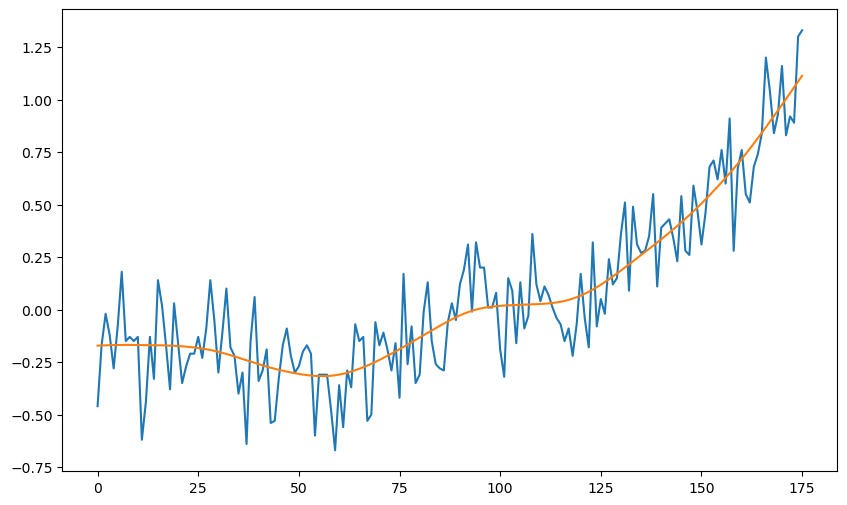

In [57]:
# Posterior mean of beta with tau_opt and sig_opt
C = 10**4
tau = tau_opt
sig = sig_opt
Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))

XTX = np.dot(X.T, X)
TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
XTy = np.dot(X.T, y)

betahat = np.dot(TempMat, XTy/(sig ** 2))
muhat = np.dot(X, betahat)

plt.figure(figsize = (10, 6))
plt.plot(y)
plt.plot(muhat)
plt.show()

Below we convert the log-posterior values to posterior values (this is the posterior over $\tau$ and $\sigma$). 

In [58]:
g['post'] = np.exp(g['logpost'] - np.max(g['logpost']))
g['post'] = g['post']/np.sum(g['post'])

In [59]:
print(g.head(10))

        tau  sig    logpost          post
0  0.000100  0.1   4.464728  4.468381e-91
1  0.000110  0.1  15.981004  4.483378e-86
2  0.000120  0.1  26.763295  2.159210e-81
3  0.000132  0.1  36.740750  4.649953e-77
4  0.000145  0.1  45.882721  4.342665e-73
5  0.000159  0.1  54.193811  1.766918e-69
6  0.000175  0.1  61.707004  3.237092e-66
7  0.000192  0.1  68.476053  2.817835e-63
8  0.000210  0.1  74.568012  1.246292e-60
9  0.000231  0.1  80.056570  3.014882e-58


We can now compute posterior means of $\tau$ and $\sigma$. 

In [60]:
tau_pm = np.sum(g['tau'] * g['post'])
sig_pm = np.sum(g['sig'] * g['post'])
print(tau_pm, tau_opt)
print(sig_pm, sig_opt)

0.0024208109728322967 0.0021544346900318843
0.17325830094841208 0.1707352647470691


Posterior means are quite close to the posterior maximizers obtained previously. 

Below we compute posterior samples of all the parameters $\beta, \tau, \sigma$. 

In [61]:
N = 1000
samples = g.sample(N, weights = g['post'], replace = True)
tau_samples = np.array(samples.iloc[:,0])
sig_samples = np.array(samples.iloc[:,1])
betahats = np.zeros((n, N))
muhats = np.zeros((n, N))
for i in range(N):
    tau = tau_samples[i]
    sig = sig_samples[i]
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))
    XTX = np.dot(X.T, X)
    TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
    XTy = np.dot(X.T, y)
    #generate betahat from the normal distribution with mean: 
    norm_mean = np.dot(TempMat, XTy/(sig ** 2)) 
    #and covariance matrix: 
    norm_cov = TempMat  
    betahat = np.random.multivariate_normal(norm_mean, norm_cov)
    muhat = np.dot(X, betahat)
    betahats[:,i] = betahat
    muhats[:,i] = muhat

From these samples, we can obtain approximations of the posterior means of $\beta$ and the fitted values $X \beta$. 

In [62]:
beta_est = np.mean(betahats, axis = 1)
mu_est = np.mean(muhats, axis = 1) #these are the fitted values

Below we plot the fitted values corresponding to the samples of $\beta$. 

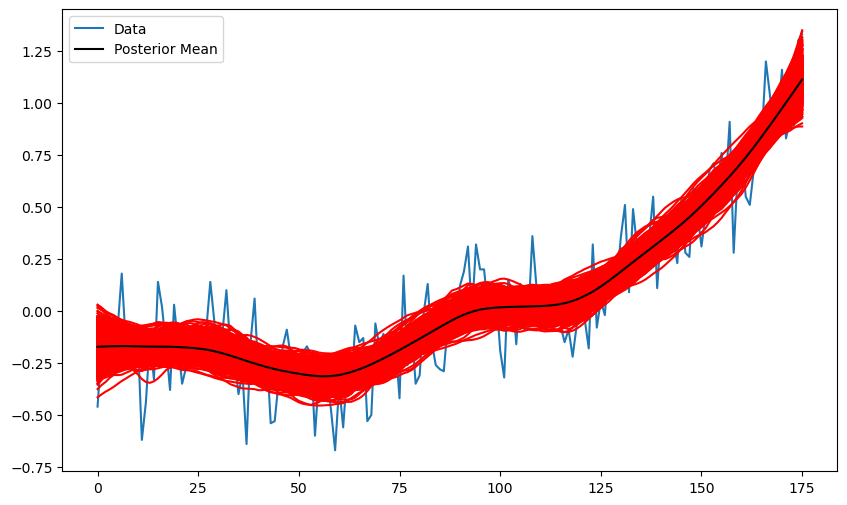

In [63]:
plt.figure(figsize = (10, 6))
plt.plot(y, label = 'Data')
for i in range(N):
    plt.plot(muhats[:,i], color = 'red')
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.legend()
plt.show()


Below are histograms of the samples of $\tau$ and $\sigma$. 

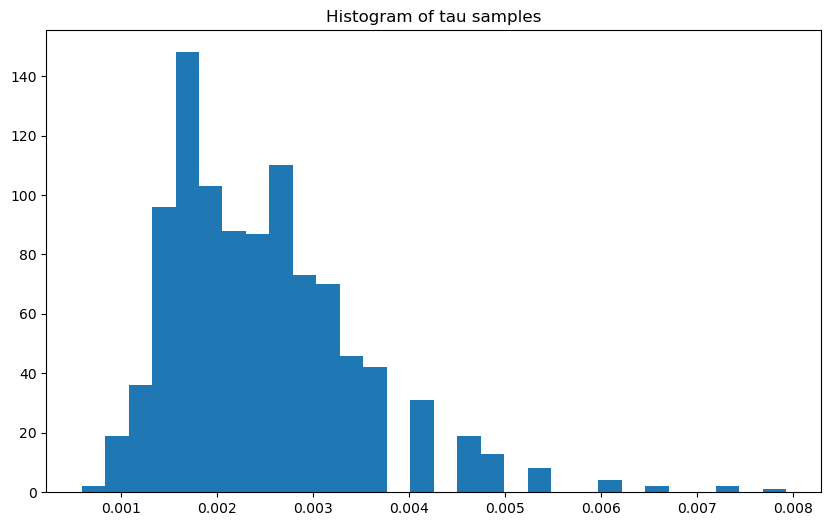

In [64]:
plt.figure(figsize=(10, 6))
plt.hist(tau_samples, bins=30)
plt.title('Histogram of tau samples')
plt.show()


It is quite interesting that the posterior samples of $\tau$ correspond to values that are neither too large (wiggly function fits) and neither too small (almost-linear function fits).

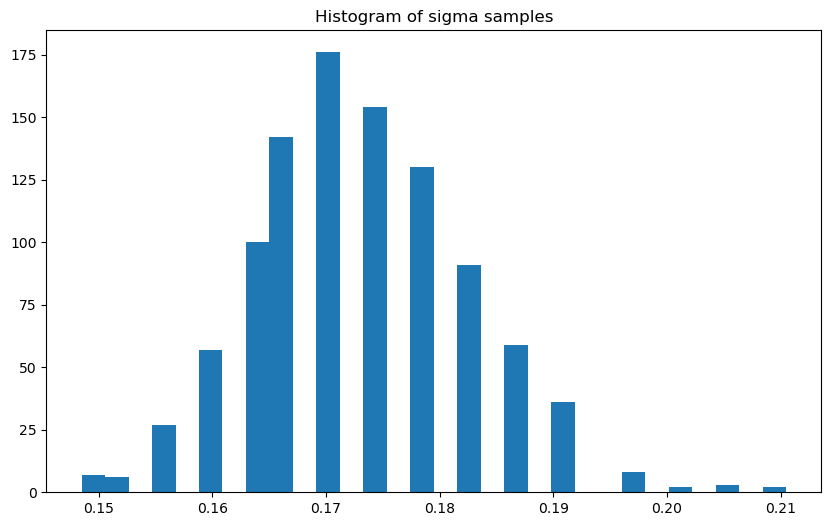

In [65]:
plt.figure(figsize=(10, 6))
plt.hist(sig_samples, bins=30)
plt.title('Histogram of sigma samples')
plt.show()
